# Classical AB Testing

## Imports

In [1]:
import scipy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as scs
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
# from ABTesting import DfHelper

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_helper import DfHelper

## Data reading

In [4]:
helper = DfHelper()
missing_values = ["n/a", "na", "undefined"]
df = helper.read_csv("../data/AdSmartABdata.csv")
df.head(5)

2021-07-22 18:35:31,372 — DfHelper — DEBUG — file read as csv


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


## Data Understanding

In [5]:
df.shape

(8077, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [7]:
df.describe()

,hour,platform_os,yes,no
count,8077.00,8077.00,8077.00,8077.00
mean,11.62,5.95,0.07,0.08
std,5.73,0.22,0.26,0.28
min,0.00,5.00,0.00,0.00
25%,7.00,6.00,0.00,0.00
50%,13.00,6.00,0.00,0.00
75%,15.00,6.00,0.00,0.00
max,23.00,7.00,1.00,1.00


## Data Exploration

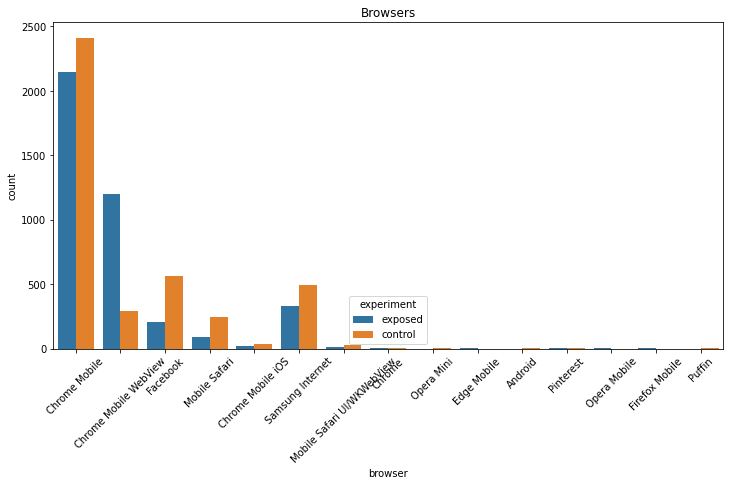

In [8]:
# browser
plt.figure(figsize=(12, 6))
sns.countplot(x="browser", hue="experiment", data=df)
plt.title('Browsers')
plt.xticks(rotation=45)
plt.show()

The most popular browser is Chrome.

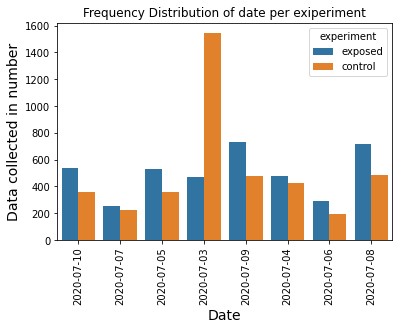

In [9]:
sns.countplot(x="date", hue="experiment", data=df)
plt.xticks(rotation=90)
plt.title('Frequency Distribution of date per exiperiment')
plt.ylabel('Data collected in number', fontsize=14)
plt.xlabel('Date', fontsize=14)

plt.show()

This shows the biggest amount of data was gathered on the first date

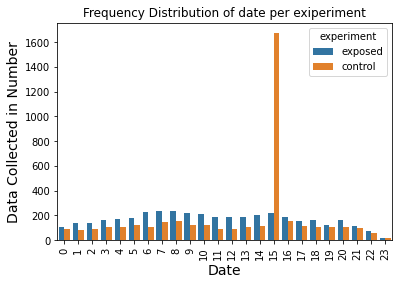

In [10]:
sns.countplot(x="hour", hue="experiment", data=df)
plt.xticks(rotation=90)
plt.title('Frequency Distribution of date per exiperiment')
plt.ylabel('Data Collected in Number', fontsize=14)
plt.xlabel('Date', fontsize=14)

plt.show()


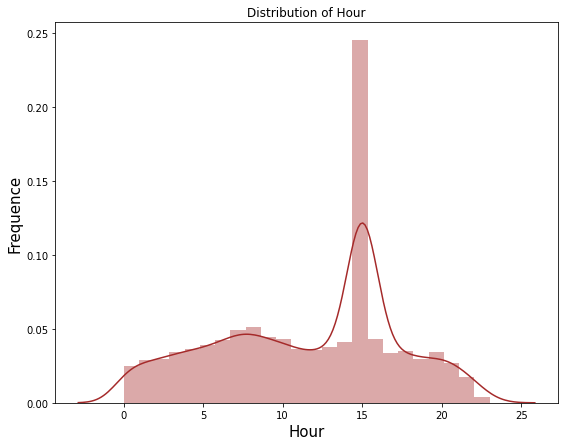

In [11]:
plt.figure(figsize=(9, 7))
ax = sns.distplot(df['hour'], bins=24, color='Brown',)
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Frequence', fontsize=15)
plt.title('Distribution of Hour')
plt.show()

This shows the biggest amount of data was gathered on the thee 15th hour


Let's see our Data distribution without the data from hour = 15

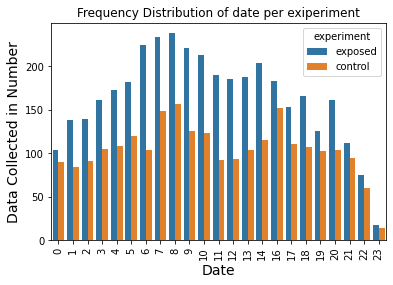

In [12]:
hour_data = df[df['hour'] != 15]
sns.countplot(x="hour", hue="experiment", data=hour_data)
plt.xticks(rotation=90)
plt.title('Frequency Distribution of date per exiperiment')
plt.ylabel('Data Collected in Number', fontsize=14)
plt.xlabel('Date', fontsize=14)

plt.show()

as shown on the graph the data gathered was uniform throught out the day

Now lets see our distrubution on the success metrics of our data sets


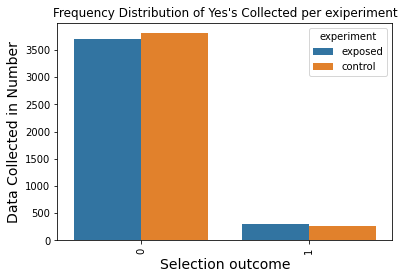

In [13]:
sns.countplot(x="yes", hue="experiment", data=df)
plt.xticks(rotation=90)
plt.title('Frequency Distribution of Yes\'s Collected per exiperiment')
plt.ylabel('Data Collected in Number', fontsize=14)
plt.xlabel('Selection outcome', fontsize=14)
plt.show()


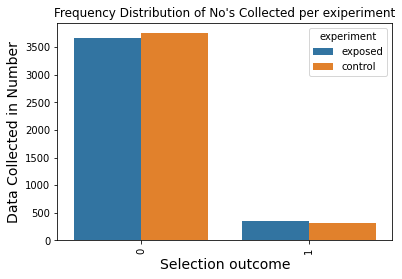

In [14]:
sns.countplot(x="no", hue="experiment", data=df)
plt.xticks(rotation=90)
plt.title('Frequency Distribution of No\'s Collected per exiperiment')
plt.ylabel('Data Collected in Number', fontsize=14)
plt.xlabel('Selection outcome', fontsize=14)
plt.show()


as shown on the graph the data gathered from the user is faily distrubuted


In [15]:
print("Exposed Group percentage: " + "{:.2f}" .format(df[df['experiment'] == 'exposed'].experiment.count()/df.experiment.count() * 100) + "%")
print("Control Group percentage: " + "{:.2f}".format(
    df[df['experiment'] == 'control'].experiment.count()/df.experiment.count() * 100) + "%")

Exposed Group percentage: 49.60%
Control Group percentage: 50.40%


Correlation

Text(0.5, 1.0, 'Heatmap indicating correlation')

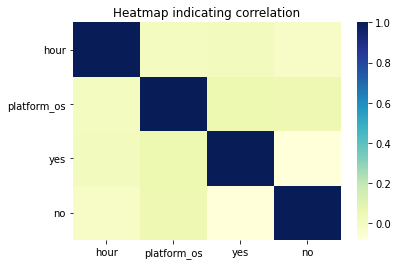

In [16]:
corr = df.corr()
sns.heatmap(corr, cmap="YlGnBu")
plt.title('Heatmap indicating correlation')

This shows there is ni significant corelation between the features.

## Data Transformation

we start by selecting columns we need for ...

In [17]:
clean_df = df[['auction_id', 'experiment', 'yes', 'no']]
clean_df.shape

(8077, 4)

We start by droping user that did not participate in the questioner.

In [18]:
clean_df = clean_df.query("not (yes == 0 & no == 0)")
clean_df.shape

(1243, 4)

transform the responses into on variable

In [19]:
clean_df['aware'] = 0
clean_df.loc[clean_df['yes'] == 1, 'aware'] = 1
clean_df.loc[clean_df['yes'] == 0, 'aware'] = 0
clean_df.drop(columns=['yes', 'no'], inplace=True)
clean_df = clean_df.set_index('auction_id')
clean_df.head(5)

,experiment,aware
auction_id,,
0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0
008aafdf-deef-4482-8fec-d98e3da054da,exposed,1
00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0
00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1
00ebf4a8-060f-4b99-93ac-c62724399483,control,0


## Let’s look at a summary of the results using the pivot table function in Pandas.

In [20]:
summary_df = clean_df.pivot_table( index='experiment', aggfunc='sum')
summary_df['total'] = clean_df.pivot_table( index='experiment', aggfunc='count')
summary_df['rate'] = clean_df.pivot_table( index='experiment')
summary_df['not aware'] = summary_df['total'] - summary_df['aware']
summary_df = summary_df.reindex(['aware', 'not aware', 'total', 'rate'], axis=1)
summary_df

,aware,not aware,total,rate
experiment,,,,
control,264,322,586,0.45
exposed,308,349,657,0.47


In [21]:
exp_rate = summary_df['rate']['exposed']
cont_rate = summary_df['rate']['control']

exp_aware = summary_df['aware']['exposed']
cont_aware = summary_df['aware']['control']

exp_total = summary_df['total']['exposed']
cont_total = summary_df['total']['control']

diff = exp_rate - cont_rate
diff

0.018285619295484168

There is around a 1.82% difference in conversion rates between the two groups. It is a good sign but this is not enough evidence for us to confidently go with the new design.

##  Compare the Two Groups


We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our experment group. 

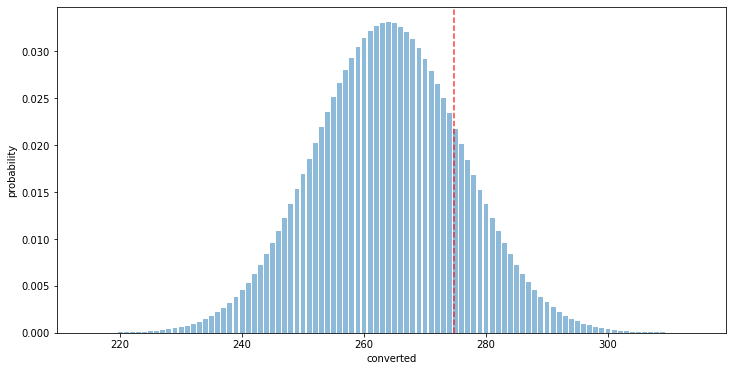

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(cont_aware-49, cont_aware+50, 100)
y = scs.binom(cont_total, cont_rate).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=exp_rate * cont_total, c='red', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')
plt.show()

We can see that the probability of getting the result from the exposed group is not very unlikely.

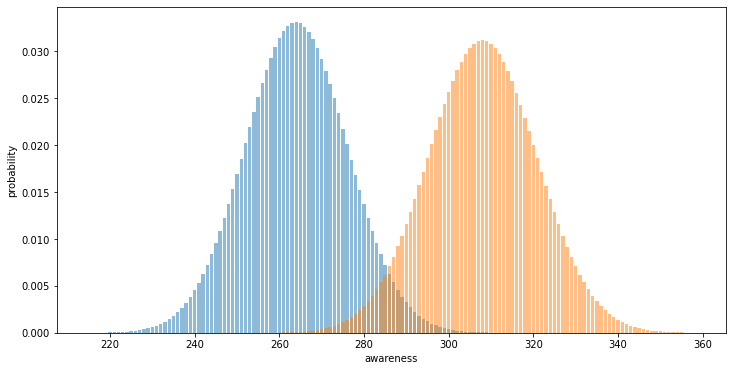

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

xC = np.linspace(cont_aware - 49, cont_aware + 50, 100)
yC = scs.binom(cont_total, cont_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5, linestyle='--')

xE = np.linspace(exp_aware - 49, exp_aware + 50, 100)
yE = scs.binom(exp_total , exp_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5, linestyle='--')

plt.xlabel('awareness')
plt.ylabel('probability')
plt.show()


From the graph we can obseve there is a shift in awareness when it comes to the exposed group.

### Bernoulli Distribution and the Central Limit Theorem

We start by considering the Bernoulli distribution for the control group.

$$ X \approx Bernoulli(p) $$
- where p is the conversion probability of the control group.

$$E(X) = p$$

$$Var(X) = p(1− p)$$

According to the central limit theorem, by calculating many sample means we can approximate the true mean of the population, $\mu$, from which the data for the control group was taken. The distribution of the sample means, p, will be normally distributed around the true mean with a standard deviation equal to the standard error of the mean. The equation for this is given as:


$$ \sigma_{\bar{x}} = \frac{s}{\sqrt{n}} = \frac{\sqrt{p(1-p)}}{\sqrt{n}} $$

Therefore, we can represent both groups as a normal distribution with the following properties:


$$ \bar{p} \approx Normal(\mu = p, \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}}) $$

standard error of the mean for both groups


In [24]:
SE_C = np.sqrt(cont_rate * (1-cont_rate)) / np.sqrt(cont_total)
SE_E = np.sqrt(exp_rate * (1-exp_rate)) / np.sqrt(exp_total)

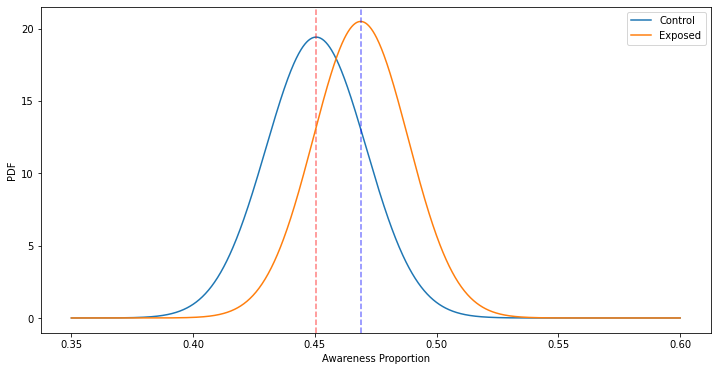

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(cont_rate, SE_C).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=cont_rate, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exp_rate, SE_E).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=exp_rate, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.show()

The graph in blue is control group distribution and in orange is exposed group distribution. The dashed lines represent the mean conversion rate for each group. 

## Variance of the Sum

A basic property of variance is that the variance of the sum of two random independent variables is the sum of the variances.


$$ Var(X+Y) = Var(X) + Var(Y)$$
$$ Var(X+Y) = Var(X) - Var(Y)$$

This means that the null hypothesis and alternative hypothesis will have the same variance which will be the sum of the variances for the control group and the test group.

${\displaystyle {\begin{aligned}Var(\hat{d}) &
                 = Var(\hat{P}_C) + Var(\hat{P}_E) \\&
                 = Var(\hat{P}_C) - Var(\hat{P}_E) \\&
                 = \frac{ P_C(1-P_C)}{n_C} + \frac{ P_E(1-P_E)}{n_E} \\&
\end{aligned}}}$

The standard deviation can then be calculated as:

$$ \sigma =  \sqrt{Var(\hat{d})} = = \sqrt{\frac{ P_C(1-P_C)}{n_C} + \frac{ P_E(1-P_E)}{n_E}}$$

If we put this equation in terms of standard deviation for the Bernoulli distribution, s:


$$ \sigma =  \sqrt{Var(\hat{d})} = = \sqrt{\frac{ S_C^2}{n_C} + \frac{ S_E^2}{n_E}}$$

${\displaystyle {\begin{aligned} \sigma &
                 = \sqrt{Var(\hat{d})} \\&
                 = \sqrt{\frac{ S_p^2}{n_C} + \frac{ S_p^2}{n_E}} \\&
                 = \sqrt{ S_p^2 (\frac{2}{n_C} + \frac{ 1}{n_E})} \\&
                 = \sqrt{ \hat{P_p}(1- \hat{P_p}) (\frac{1}{n_C} + \frac{ 1}{n_E})} \\&
\end{aligned}}}$

- where: $$ \hat{P_p} = \frac{p_Cn_C + p_En_E}{n_C+n_E}$$


In [57]:
std_cont = np.sqrt(cont_rate * (1 - cont_rate) / cont_total)
std_exp = np.sqrt(exp_rate * (1 - exp_rate) / exp_total)
std_cont, std_exp

(0.02055339057798332, 0.019468837373132736)

With that, we now have enough information to construct the distributions for the null hypothesis and the alternative hypothesis.

## Compare the Null Hypothesis vs. the Alternative Hypothesis

- H0: there’s no difference in brand awareness between the 2 groups
- H1: There's a difference in brand awareness.


In [26]:
from plot import *

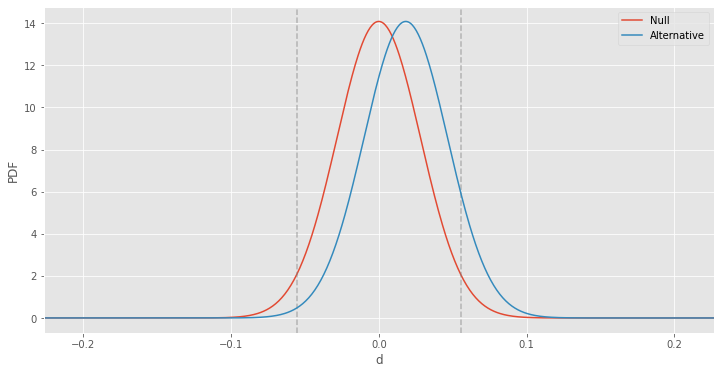

In [27]:
abplot(cont_total, exp_total, cont_rate, diff)

We can see that the alternative hypothesis curve suggests that the exposed group has a higher conversion rate than the control group. 

## Calculate z-score and p-value.

In [62]:
z_score = (diff) / np.sqrt(std_cont**2 + std_exp**2)
print(f"zscore is {z_score:0.5f}, with p-value {scs.norm().sf(z_score):0.5f}")

zscore is 0.64590, with p-value 0.25917


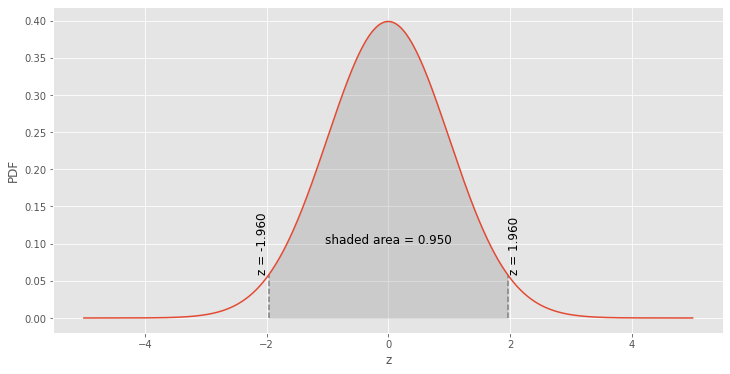

In [63]:
zplot(area=0.95)

We get a p-value of 0.259 that is greater than 0.05(significance level). Based on the p-value we failed to reject the Null hypotesis.


## Statistical Power and Significance Level

After running our experiment, we get a resulting conversion rate for both groups. If we calculate the difference between the conversion rates, we end up with one result, the difference or the effect of the design change. Our task is to determine which population this result came from, the null hypothesis or the alternative hypothesis.


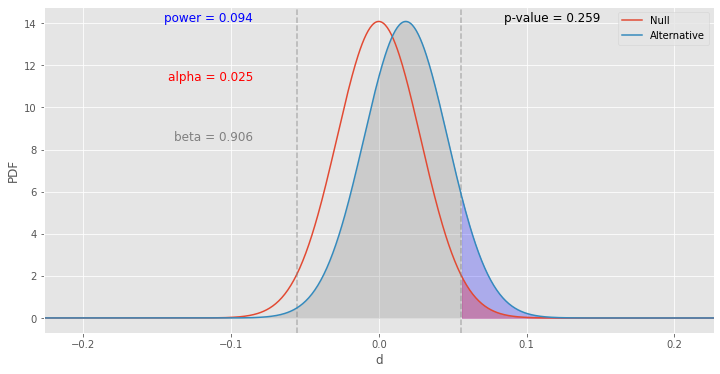

In [28]:
abplot(cont_total, exp_total, cont_rate, diff, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)

- The null hypothesis wich is $\alpha$ is the red.
- The alternate hypothesis is the blue one.
- The gray dashed lines are confidence interval at 95% (0.05).

We go a p-value of 0.259 that is greater than aor significance level which is 0.05. Based on the p-value we failed to reject the Null hypotesis. 

As we can see we get small value for power which is 9.4 % . This indicates there is 90.6 % chance that we can make a type-II error wich is $\beta$. This indicates there is a very high probability that we have made a type-II error. We need to gather more data to make a sounding conclusion from this testing.


## Confidence level


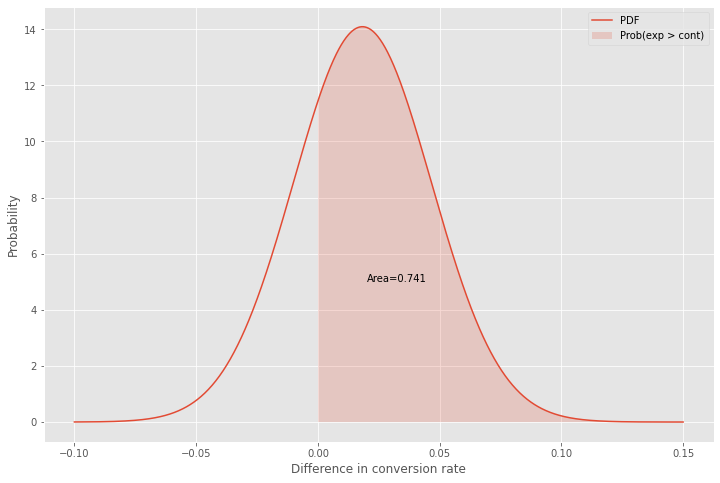

In [38]:
p = scs.norm(diff, np.sqrt(std_cont**2 + std_exp**2))
x = np.linspace(-0.1, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.subplots(figsize=(12, 8))
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x > 0, label="Prob(exp > cont)", alpha=0.2)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate")
plt.ylabel("Probability")
plt.show()

We get a value of 0.741 confidence interval. What this telling is is 74.1 % of time the exposed group has same awareness with the control group and 25.1 % of a time the exposed group has different awareness with the control group


## Conducting optimal sample size

lets start by looking at how much more data we need to get the power to 80%.

In [40]:
def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    standard_norm = scs.norm(0, 1)
    Z_beta = standard_norm.ppf(power)
    Z_alpha = standard_norm.ppf(1-sig_level/2)
    pooled_prob = (bcr + bcr+mde) / 2
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2/ mde**2)
    return min_N

In [47]:
power = 0.8
sig_level = 0.05
sample_80 = round(min_sample_size(cont_rate, diff, power,  sig_level))
print(f'Minimum sample size for 80% power is : {sample_80} ')

Minimum sample size for 80% power is : 11661 


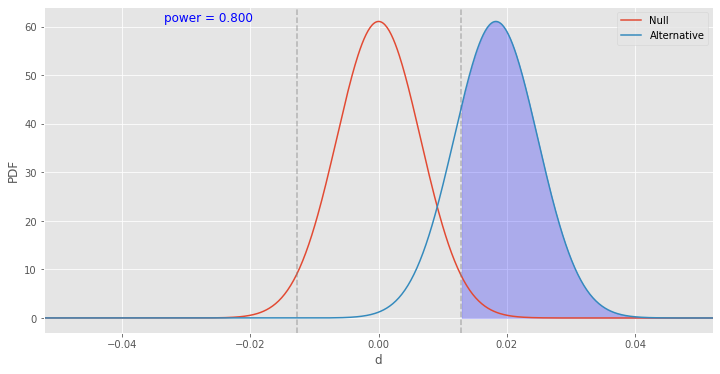

In [48]:
abplot(sample_80, sample_80, cont_rate, diff, show_power=True)

Now lets look at how much more data we need to get the power to 90 % .

In [50]:
power = 0.9
sig_level = 0.05
sample_80 = round(min_sample_size(cont_rate, diff, power,  sig_level))
print(f'Minimum sample size for 80% power is : {sample_80} ')

Minimum sample size for 80% power is : 15610 


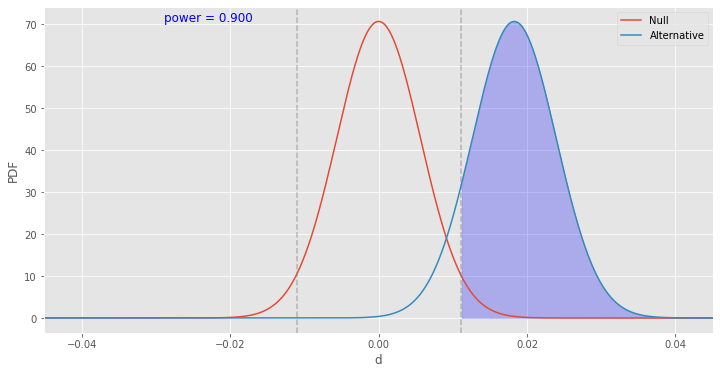

In [51]:
abplot(sample_80, sample_80, cont_rate, diff, show_power=True)

What if we decrease the significance level

In [54]:
power = 0.8
sig_level = 0.1
sample_80 = round(min_sample_size(cont_rate, diff, power,  sig_level))
print(f'Minimum sample size for 80% power is : {sample_80} ')

Minimum sample size for 80% power is : 9185 


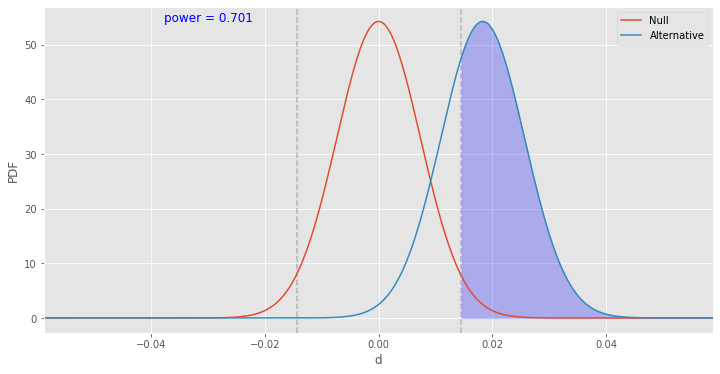

In [55]:
abplot(sample_80, sample_80, cont_rate, diff, show_power=True)

## Reference

The Math Behind A/B Testing with Example Python Code

https: // towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f